### Importing libraries

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import gensim
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
pd.set_option("display.max_colwidth", 200)
sns.set()

### Helper functions

In [51]:


def plot_model_metric(result_df,metric,title):
    plt.figure(figsize=(16,9));
    g = sns.barplot(x='FeatureExtractor',y=metric,hue='Model',data=results[['FeatureExtractor','Model',metric]]);

    for p in g.patches:
        g.annotate(format(100*p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center',
                   va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')
    g.set_yticklabels([]);
    g.axes.get_yaxis().set_visible(False)
    g.set_title(title);

def extract_results_from_models(method,model_dict):
    cols = ['FeatureExtractor','Model','TrainAccMean','TrainAccStd','CVAccMean','CVAccStd']
    res_df = pd.DataFrame(columns=cols)
    
    for model_name,model in model_dict.items():

        model_cv_df = pd.DataFrame(model.cv_results_)
        best_row = model_cv_df[model_cv_df.rank_test_score==1]
        train_acc_mean = float(best_row.mean_train_score)
        train_acc_std = float(best_row.std_train_score)
        cv_acc_mean = float(best_row.mean_test_score)
        cv_acc_std = float(best_row.std_test_score)
        
        
        model_metrics = {'FeatureExtractor':method,
               'Model':model_name,
               'TrainAccMean':train_acc_mean,'TrainAccStd':train_acc_std,
               'CVAccMean':cv_acc_mean,'CVAccStd':cv_acc_std
               }
        res_df = res_df.append(model_metrics,ignore_index=True)
        
    return res_df


    
def word_vector(tokens, size,model_w2v):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

def train_and_cv_models(X,y,nfolds=3,random_state=42,w2v=False):
    
    RS = random_state
    kf = KFold(n_splits=nfolds,shuffle=True,random_state=RS)
    
    if not w2v:
        print('Training NaiveBayes')

    model_nb = MultinomialNB()
    grid_search_nb = GridSearchCV(estimator=model_nb,
                              param_grid = {'alpha':[0,0.5,1]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)

    if not w2v:
        grid_search_nb.fit(X,y)
    
    print('Training LogisticRegression')
    log_reg_model = LogisticRegression(random_state=RS,solver='sag',n_jobs=-1)
    grid_search_logreg = GridSearchCV(estimator=log_reg_model,
                               param_grid={'C':[0.1,1,10,100]},
                               scoring='accuracy',
                               cv=kf,
                               n_jobs=-1,
                               verbose=1,return_train_score=True)
    grid_search_logreg.fit(X,y)
    
    print('Training SVM')
    svm_model = LinearSVC(random_state=RS)
    grid_search_svm = GridSearchCV(estimator=svm_model,
                              param_grid = {'C':[0.01,0.1,1,10,100]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)
    grid_search_svm.fit(X,y)

    print('Training XGB')

    model_xgb = XGBClassifier(random_state=RS,n_jobs=-1)
    grid_search_xgb = GridSearchCV(estimator=model_xgb,
                              param_grid = {'max_depth':[3],
                                           'n_estimators':[100],
                                           },
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)

    grid_search_xgb.fit(X,y)
    
    print('Training RandomForest')

    model_rf = RandomForestClassifier(random_state=RS,n_jobs=-1)
    grid_search_rf = GridSearchCV(estimator=model_rf,
                              param_grid = {'n_estimators':[50,100]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)

    grid_search_rf.fit(X,y)
    
    
    
    
    print('Training DecisionTree')

    model_dt = DecisionTreeClassifier(random_state=RS)
    grid_search_dt = GridSearchCV(estimator=model_dt,
                              param_grid = {'criterion':['gini','entropy']},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=2,return_train_score=True)

    grid_search_dt.fit(X,y)
    
    
    
    print('Trained all models')
    
    model_dict = {'LOG_REG':grid_search_logreg,
              'SVM':grid_search_svm,
              'NB':grid_search_nb,
              'XGB':grid_search_xgb,
              'RF':grid_search_rf,   
              'DT':grid_search_dt}
    if w2v:
        del model_dict['NB']
    
    return model_dict

def evaluate_models(model_dict,actual_y,test_data):

    for name,model in model_dict.items():

        print(name)
        
        if(name)=='SVM':
            pred_margins = model.best_estimator_.decision_function(test_data)
            prediction = 1 - (pred_margins - pred_margins.min())/(pred_margins.max() - pred_margins.min())
        else:
            estimator = model.best_estimator_
            prediction = estimator.predict_proba(test_data)[:,0]

        eval_func(actual=actual_y,prediction=prediction,roc=True)
    pass


def get_wordcounts_df(text,stop=True):
    tokens = word_tokenize(text)
    f = FreqDist(tokens)
    words_df = pd.DataFrame({'word':list(f.keys()), 'count':list(f.values())})
    
    if(stop):
        tokens_stop = [token for token in tokens if (token not in stop_words)]
        f_stop = FreqDist(tokens_stop)
        words_df_stop = pd.DataFrame({'word':list(f_stop.keys()), 'count':list(f_stop.values())})
        return words_df,words_df_stop
    else:
        return words_df

def eval_func(actual,prediction,roc=False,thresh=0.5):
    
    
    if roc:
        
        fpr, tpr, thresholds = roc_curve(actual, prediction)
        roc_auc = auc(tpr, fpr)

        
    prediction = prediction <= thresh
    prediction = prediction.astype(np.int)
        
    print('Accuracy = ',100*accuracy_score(actual,prediction))
    print('Confusion Matrix :')
    print(confusion_matrix(actual,prediction)*100/len(actual))
    
    if roc:
        plt.figure()
        plt.plot(tpr, fpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    pass



def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

def process_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def get_metrics(actual,prediction,thresh=0.5):
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    
    
    prediction = prediction <= thresh
    prediction = prediction.astype(np.int)
    
    accuracy = accuracy_score(actual,prediction)
    f1score = f1_score(actual,prediction)
    recall = recall_score(actual,prediction)
    precision = precision_score(actual,prediction)
    roc_auc = auc(tpr, fpr)
    
    return accuracy,f1score,recall,precision,roc_auc

### Data Import and cleaning

In [141]:
data = pd.read_csv('train.csv',encoding = "ISO-8859-1")

In [142]:
data.drop(['ItemID'],axis=1,inplace=True)

In [143]:
data.columns = ['sentiment','tweet']

In [144]:
data.shape

(99989, 2)

In [145]:
print('Removing tags')
data['processed_tweet'] = data['tweet'].map(lambda x: re.sub("@\S+", ' ', x))

print('Lowercasing')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: x.lower())

print('Removing numbers')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: re.sub(r'\d+', ' ', x))

print('Removing links')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: re.sub("https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', x))

print('Handling Emojis')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: handle_emojis(x))


print('Removing punctuation')
data['processed_tweet']  = data['processed_tweet'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

print('Removing white spaces')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: x.strip())

print('Tokenizing')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: word_tokenize(x))
 
print('Removing non alpha tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [word for word in x if word.isalpha()])

print('Removing stop words')
stop_words = set(stopwords.words('english'))
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [w for w in x if not w in stop_words and len(w)>1])

print('processing tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [process_word(word) for word in x])

print('Lemmatization')
lem = WordNetLemmatizer()
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

print('Joining tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: ' '.join(x))

print('Done')

Removing tags
Lowercasing
Removing numbers
Removing links
Handling Emojis
Removing punctuation
Removing white spaces
Tokenizing
Removing non alpha tokens
Removing stop words
processing tokens
Lemmatization
Joining tokens
Done


### Inspecting the data

In [8]:
data.sample(10)

,sentiment,tweet,processed_tweet
34469,1,@akarshsimha: Started using the branch,start use branch
85232,1,@cdlastimosa The HILLS.,hill
64717,1,"@bradiewebbstack what movie, coz it has to be a good one",movie coz good one
14363,1,...and im tryin to finish up narnia..,im tryin finish narnia
41881,0,"@AndrewChavez ,You are by far the best tweeter. [I think I was too aroused last night to have any dreams. See you Sunday, dearest. ]",far best tweeter think arouse last night dream see sunday dearest
19988,0,@ onti1 yes I need a ride http://snipurl.com/jl4mq,onti yes need ride mq
19420,1,@ caberet with Nicole. Never a day off. I kinda like it,caberet nicole never day kinda like
19330,1,?currently watching paano ba ang mangarap?,currently watch paano ba ang mangarap
78612,0,@ariannamartinez we can't take pictures in the rain.,take picture rain
67642,0,@BrookRiley Honest to goodness I think it's a gene - I think you're either an early or late person! U poor girl.That's how I feel at 10P,honest goodness think gene think either early late person poor girl feel


In [9]:
#Checking for null values
data.isna().sum()

sentiment          0
tweet              0
processed_tweet    0
dtype: int64

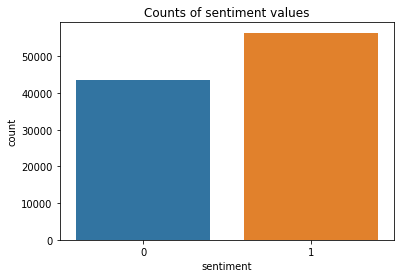

In [10]:
#Sentiment values percentage
sns.countplot(data.sentiment);
plt.title('Counts of sentiment values');

In [11]:
print('Distribution of sentiments')
data.sentiment.value_counts()*100/len(data)

Distribution of sentiments


1    56.463211
0    43.536789
Name: sentiment, dtype: float64

### Distribution of lengths

In [12]:
data['lengths'] = [len(str(t)) for t in data.tweet]

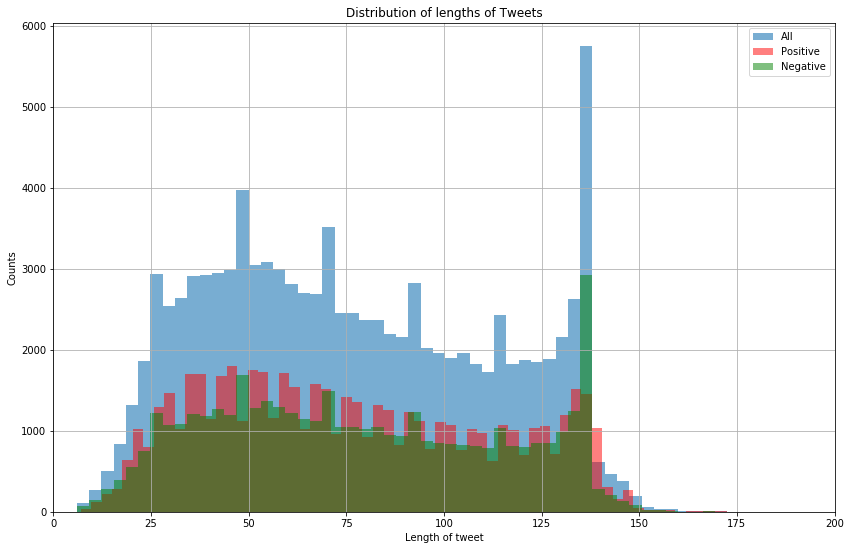

In [13]:
plt.figure(figsize=(14,9));
plt.xlim(0,200);
data.lengths.hist(density=False,bins=300,alpha=0.6,label='All');
data[data.sentiment==1].lengths.hist(density=False,bins=100,alpha=0.5,label='Positive',color='red');
data[data.sentiment==0].lengths.hist(density=False,bins=300,alpha=0.5,label='Negative',color='green');
plt.title('Distribution of lengths of Tweets')
plt.xlabel('Length of tweet')
plt.ylabel('Counts')
plt.legend();


### Inspecting negative sentiment

In [14]:
data[data.sentiment==0].sample(15,random_state=2)

,sentiment,tweet,processed_tweet,lengths
731,0,;( noooo! why? things are so complicated if I spelt that wrong idc,noo things complicate spell wrong idc,67
66061,0,@bliss_ke I did...sadness I wanna get my nose pierced I might just say fuck it and do it...lol or get another tat...idk yet,sadness wan na get nose pierce might say fuck lol get another tat idk yet,124
47358,0,@alltony no its the same day as edgefest lol TEXT ME i dont know why i dont have your number in my phone,day edgefest lol text dont know dont number phone,106
66528,0,"@blue_id_grl01 I know - very immature for people to react to ANY celeb that way, huh. Thank God he had security! He was so nice about it",know immature people react celeb way huh thank god security nice,137
24673,0,@acidcode i never even having known them...,never even know,44
6158,0,saddness let me no if i can,saddness let,28
29514,0,@acummings it was good although the $5 special is only pepperoni. Unfortunately they skimped on the sauce,good although special pepperoni unfortunately skimp sauce,106
24863,0,"@30SECONDSTOMARS wow you guys are cool for spreading the summit across the world,oh but you always forget out Scotland when you tour",wow guy cool spread summit across world oh always forget scotland tour,134
645,0,why me?,,9
425,0,Exercise 2 build muscle mass is only thing that speeds metabolism: http://tinyurl.com/bvagbj,exercise build muscle mass thing speed metabolism,94


### Inspecting positive sentiment

In [15]:
data[data.sentiment==1].sample(15,random_state=2)

,sentiment,tweet,processed_tweet,lengths
97607,1,"@CokoClemons oh, all is peachy with me! you reeeeeaaady for your releeeeeeaaase???",oh peachy reeaady releeaase,84
14808,1,"(@lovelightliz) note to self: when awed/ amazed/ etc. about something, the correct expression to utter is &quot;Fascinating!&quot;",note self awe amaze etc something correct expression utter quot fascinate quot,131
50212,1,@askaaronlee Great! I look forward to it!,great look forward,42
31984,1,@Aftashok it will move..u gotta have faith,move get ta faith,43
70752,1,@brenleigh Happy Friday to you too! I'm so ready for a long weekend,happy friday ready long weekend,70
65717,1,"@blakebillingsly Naah, not the porn bots fault and there wouldn't be foul play.... but you probably secretly clicked on one..didn't you?",naah porn bots fault foul play probably secretly click one,137
12444,1,&quot;A margarita a day makes work more like play&quot;,quot margarita day make work like play quot,56
31471,1,@AdrianDinArad succes,succes,23
92900,1,@Chrissy89 @FallOutCookGirl you know - if u didn't watch the first part it was good...I do miss him!,know watch first part good miss,101
61614,1,@Big_Frame hey its cool...everyone is welcome! When you see us discussing just join on in!,hey cool everyone welcome see us discuss join,91


### Wordclouds

In [16]:
pos_data = data[data.sentiment==1]
neg_data = data[data.sentiment==0]
pos_text = ' '.join(str(t) for t in pos_data.processed_tweet)
neg_text = ' '.join(str(t) for t in neg_data.processed_tweet)

Positive Sentiment

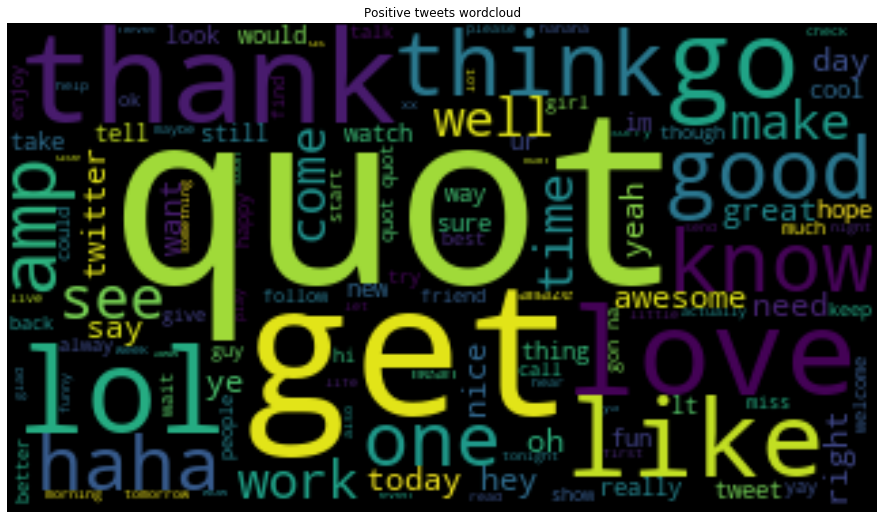

In [17]:
wc_pos = WordCloud(width=320,height=180,stopwords=stop_words).generate(pos_text)
plt.figure(figsize=(16,9))
plt.title('Positive tweets wordcloud')
plt.axis('off')
plt.imshow(wc_pos,interpolation='bilinear');

In [18]:
pos_d = get_wordcounts_df(pos_text,stop=False)

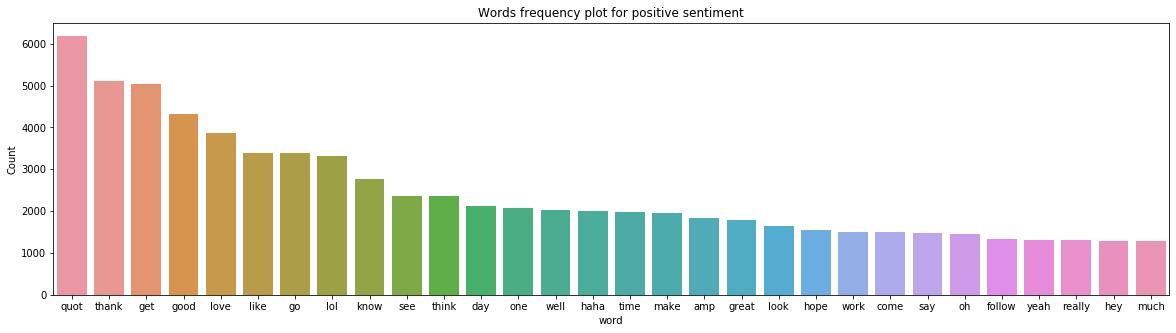

In [19]:
d = pos_d.nlargest(columns="count", n = 30) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Words frequency plot for positive sentiment')
plt.show()

### Negative Sentiment

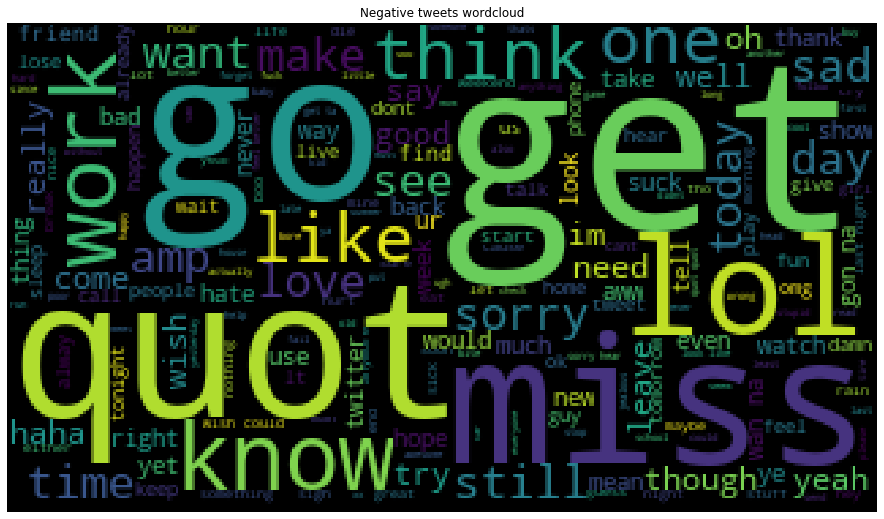

In [20]:
wc_neg = WordCloud(width=320,height=180,stopwords=stop_words).generate(neg_text)
plt.figure(figsize=(16,9))
plt.title('Negative tweets wordcloud')
plt.axis('off')
plt.imshow(wc_neg);

In [21]:
neg_d = get_wordcounts_df(neg_text,stop=False)

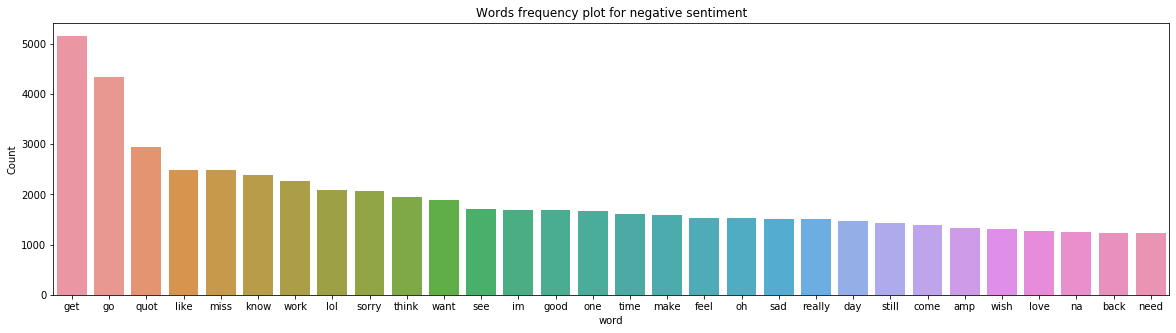

In [22]:
d = neg_d.nlargest(columns="count", n = 30) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Words frequency plot for negative sentiment')
plt.show()

## Creating Model

Splitting the data

In [173]:
X_train, X_test,y_train,y_test = train_test_split(data.processed_tweet,
                                                 data.sentiment,
                                                 test_size=0.2,
                                                 random_state=RS)

### BOW

In [174]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1),max_features=3000)
bow_tr = bow_vectorizer.fit(data['processed_tweet'])

In [176]:
X_train_bow = bow_tr.transform(X_train)
X_test_bow = bow_tr.transform(X_test)

In [165]:
bow_models = train_and_cv_models(X_train_bow,y_train,nfolds=3,random_state=RS)

Training NaiveBayes
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    7.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.6s finished
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   26.8s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   38.2s finished


Training XGB
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


Training RandomForest
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished


Training DecisionTree
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   18.7s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   19.2s finished


Trained all models


In [166]:
extract_results_from_models('BOW',bow_models)

,FeatureExtractor,Model,TrainAccMean,TrainAccStd,CVAccMean,CVAccStd
0,BOW,LOG_REG,0.769830,0.001403,0.738096,0.000265
1,BOW,SVM,0.769580,0.000605,0.736983,0.000849
2,BOW,NB,0.758942,0.000581,0.737095,0.001377
3,BOW,XGB,0.685565,0.002639,0.680652,0.004457
4,BOW,RF,0.976885,0.000493,0.717993,0.001447
5,BOW,DT,0.976916,0.000491,0.668888,0.001787


### TF-IDF

In [177]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),max_features=3000)
tfidf = tfidf_vectorizer.fit(data['processed_tweet'])

In [178]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [161]:
tfidif_models = train_and_cv_models(X_train_tfidf,y_train,nfolds=3,random_state=RS)

Training NaiveBayes
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    3.7s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.2s finished


Training SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   16.4s finished


Training XGB
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


Training RandomForest
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.0min finished


Training DecisionTree
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   21.6s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   24.8s finished


Trained all models


In [167]:
extract_results_from_models('TFIDF',tfidif_models)

,FeatureExtractor,Model,TrainAccMean,TrainAccStd,CVAccMean,CVAccStd
0,TFIDF,LOG_REG,0.768249,0.000805,0.739808,0.000542
1,TFIDF,SVM,0.767643,0.000807,0.739871,0.000922
2,TFIDF,NB,0.758217,0.000717,0.733157,0.000327
3,TFIDF,XGB,0.686258,0.003049,0.679139,0.004392
4,TFIDF,RF,0.976710,0.000521,0.726419,0.002346
5,TFIDF,DT,0.976722,0.000514,0.671601,0.002833


### Word2Vec

In [33]:
model_w2v = gensim.models.Word2Vec(
            data.processed_tweet,
            size=1000, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 8, # no.of cores
            seed = RS)

model_w2v.train(data.processed_tweet, total_examples= len(data.processed_tweet), epochs=20)

(13090537, 74879980)

In [34]:
wordvec_arrays = np.zeros((len(data.processed_tweet), 1000))

for i in range(len(data.processed_tweet)):
    wordvec_arrays[i,:] = word_vector(data.processed_tweet[i], 1000,model_w2v)
    
#wordvec_df = pd.DataFrame(wordvec_arrays)
#wordvec_df.shape

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [181]:
X_train_w2v = wordvec_arrays[y_train.index,:]
X_test_w2v = wordvec_arrays[y_test.index,:]

In [36]:
word2vec_models = train_and_cv_models(X_train_w2v,y_train,nfolds=3,random_state=RS,w2v=True)

Training LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.9min remaining:   34.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.5min finished
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 28.4min remaining: 24.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 37.8min finished
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training XGB
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 13.3min finished


Training RandomForest
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.4min finished


Training DecisionTree
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   57.9s remaining:   57.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.0min finished


Trained all models


In [39]:
extract_results_from_models('W2V',word2vec_models)

,FeatureExtractor,Model,TrainAccMean,TrainAccStd,CVAccMean,CVAccStd
0,W2V,LOG_REG,0.595142,0.001879,0.593117,0.005842
1,W2V,SVM,0.595417,0.001232,0.592504,0.005994
2,W2V,XGB,0.626758,0.000899,0.607056,0.004873
3,W2V,RF,0.988205,0.000353,0.607343,0.004190
4,W2V,DT,0.988205,0.000353,0.551787,0.003365


### Analysis of results

In [40]:
results = extract_results_from_models('BOW',bow_models). \
append(extract_results_from_models('TFIDF',tfidif_models)). \
append(extract_results_from_models('W2V',word2vec_models)).reset_index(drop=True)

Results sorted by descending CrossValidation errors

In [44]:
results.sort_values('CVAccMean',ascending=False).reset_index(drop=True)

,FeatureExtractor,Model,TrainAccMean,TrainAccStd,CVAccMean,CVAccStd
0,TFIDF,SVM,0.767643,0.000807,0.739871,0.000922
1,TFIDF,LOG_REG,0.768249,0.000805,0.739808,0.000542
2,BOW,LOG_REG,0.769830,0.001403,0.738096,0.000265
3,BOW,NB,0.758942,0.000581,0.737095,0.001377
4,BOW,SVM,0.769580,0.000605,0.736983,0.000849
5,TFIDF,NB,0.758217,0.000717,0.733157,0.000327
6,TFIDF,RF,0.976710,0.000521,0.726419,0.002346
7,BOW,RF,0.976885,0.000493,0.717993,0.001447
8,BOW,XGB,0.685565,0.002639,0.680652,0.004457
9,TFIDF,XGB,0.686258,0.003049,0.679139,0.004392


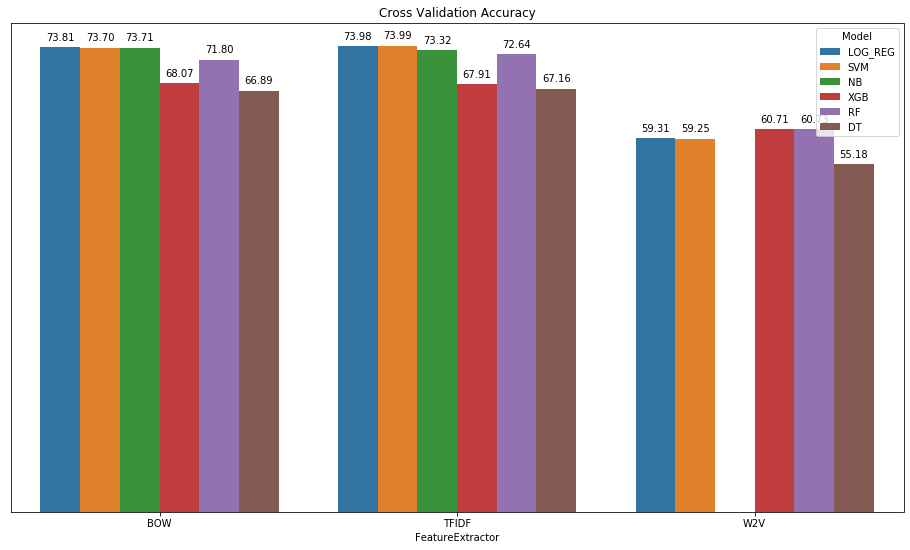

In [53]:
plot_model_metric(results,'CVAccMean','Cross Validation Accuracy')

We can see that the best performing model is the SVM using TFIDF features

### Final predictions

In [184]:
test_pred_margins = tfidif_models['SVM'].best_estimator_.decision_function(X_test_tfidf)

In [185]:
test_pred = 1- (test_pred_margins-test_pred_margins.min())/(test_pred_margins.max()-test_pred_margins.min())

Accuracy =  72.19721972197219
Confusion Matrix :
[[20.73207321 23.02230223]
 [ 4.78047805 51.46514651]]


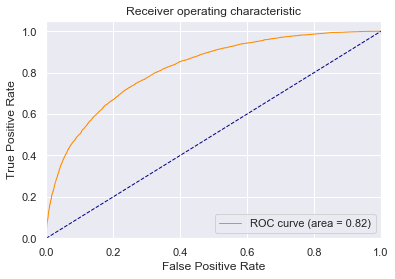

In [196]:
eval_func(actual=y_test,prediction=test_pred,roc=True)

In [189]:
test_data = data.iloc[y_test.index]

In [190]:
test_data['preds'] = np.where(test_pred<0.5,1,0)

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [193]:
pd.DataFrame(classification_report(test_data.sentiment,test_data.preds,target_names=['Negative','Positive'],output_dict=True))

,Negative,Positive,micro avg,macro avg,weighted avg
f1-score,0.598614,0.787332,0.721972,0.692973,0.704759
precision,0.812623,0.690924,0.721972,0.751773,0.744172
recall,0.473829,0.915007,0.721972,0.694418,0.721972
support,8750.000000,11248.000000,19998.000000,19998.000000,19998.000000


In [194]:
test_data[(test_data.preds!=test_data.sentiment)][['sentiment','preds','tweet']].sample(10).reset_index(drop=True)

,sentiment,preds,tweet
0,0,1,"&quot;I got a caramel apple,&quot; &quot;What did you get, Charlie Brown?&quot; &quot;I got a rock.&quot;"
1,1,0,#Squarespace gimme an iPhone already
2,0,1,"@billyraycyrus Hello, Do You Answare Fans? i have been told miley cyrus dont :/ bad for me i rlly wanna chat her -.-"
3,0,1,"@andyfortson i can't believe we don't hang out and drink whiskey. oh wait, i'm always busy."
4,0,1,@aligh Bleeeh i dont like my hair at all
5,1,0,@bobbywatson hope yesterday went well I won't be in #borough tonight tho...
6,0,1,"@bethdelusional mum washed my Joe fork, he's juiceless"
7,0,1,@BreeOlson9 I do but I never get any replies lol
8,0,1,".@tsuasai was sweet and brought home some Thai tea for me. Then she was clumsy, and dropped it on our garage floor."
9,1,0,@ashleytisdale you should do something for the people who dont have cable


In [ ]:
# 1. change method to FeatureExtractions
# 2. Elimate testdata from evaluation
# 4. Add Mean,std CV and Train scores 
# 3. Fix svm predictions